In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 300
rcParams["savefig.dpi"] = 300

from celerite import plot_setup
plot_setup.setup()

# Python: Modeling

This tutorial will demonstrate how you can use the modeling protocol in celerite to fit for the mean parameters simultaneously with the kernel parameters.

In this example, we’re going to simulate a common data analysis situation where our dataset exhibits unknown correlations in the noise. When taking data, it is often possible to estimate the independent measurement uncertainty on a single point (due to, for example, Poisson counting statistics) but there are often residual systematics that correlate data points. The effect of this correlated noise can often be hard to estimate but ignoring it can introduce substantial biases into your inferences. In the following sections, we will consider a synthetic dataset with correlated noise and a simple non-linear model. We will fit these data by modeling the covariance structure in the data using a Gaussian process.


## A Simple Mean Model

The model that we’ll fit in this demo is a single Gaussian feature with three parameters: amplitude $\alpha$, location $\ell$, and width $\sigma^2$. I’ve chosen this model because is is the simplest non-linear model that I could think of, and it is qualitatively similar to a few problems in astronomy (fitting spectral features, measuring transit times, etc.).


## Simulated Dataset

Let's start by simulating a dataset of 50 points with known correlated noise. In fact, this example is somewhat artificial since the data were drawn from a Gaussian process but in everything that follows, we’ll use a different kernel function for our inferences in an attempt to make the situation slightly more realistic. A known white variance was also added to each data point.

Using the parameters

$$\alpha = −1 \quad, \quad\quad \ell = 0.1 \quad, \quad\quad \sigma^2 = 0.4 \quad.$$

the resulting dataset is:

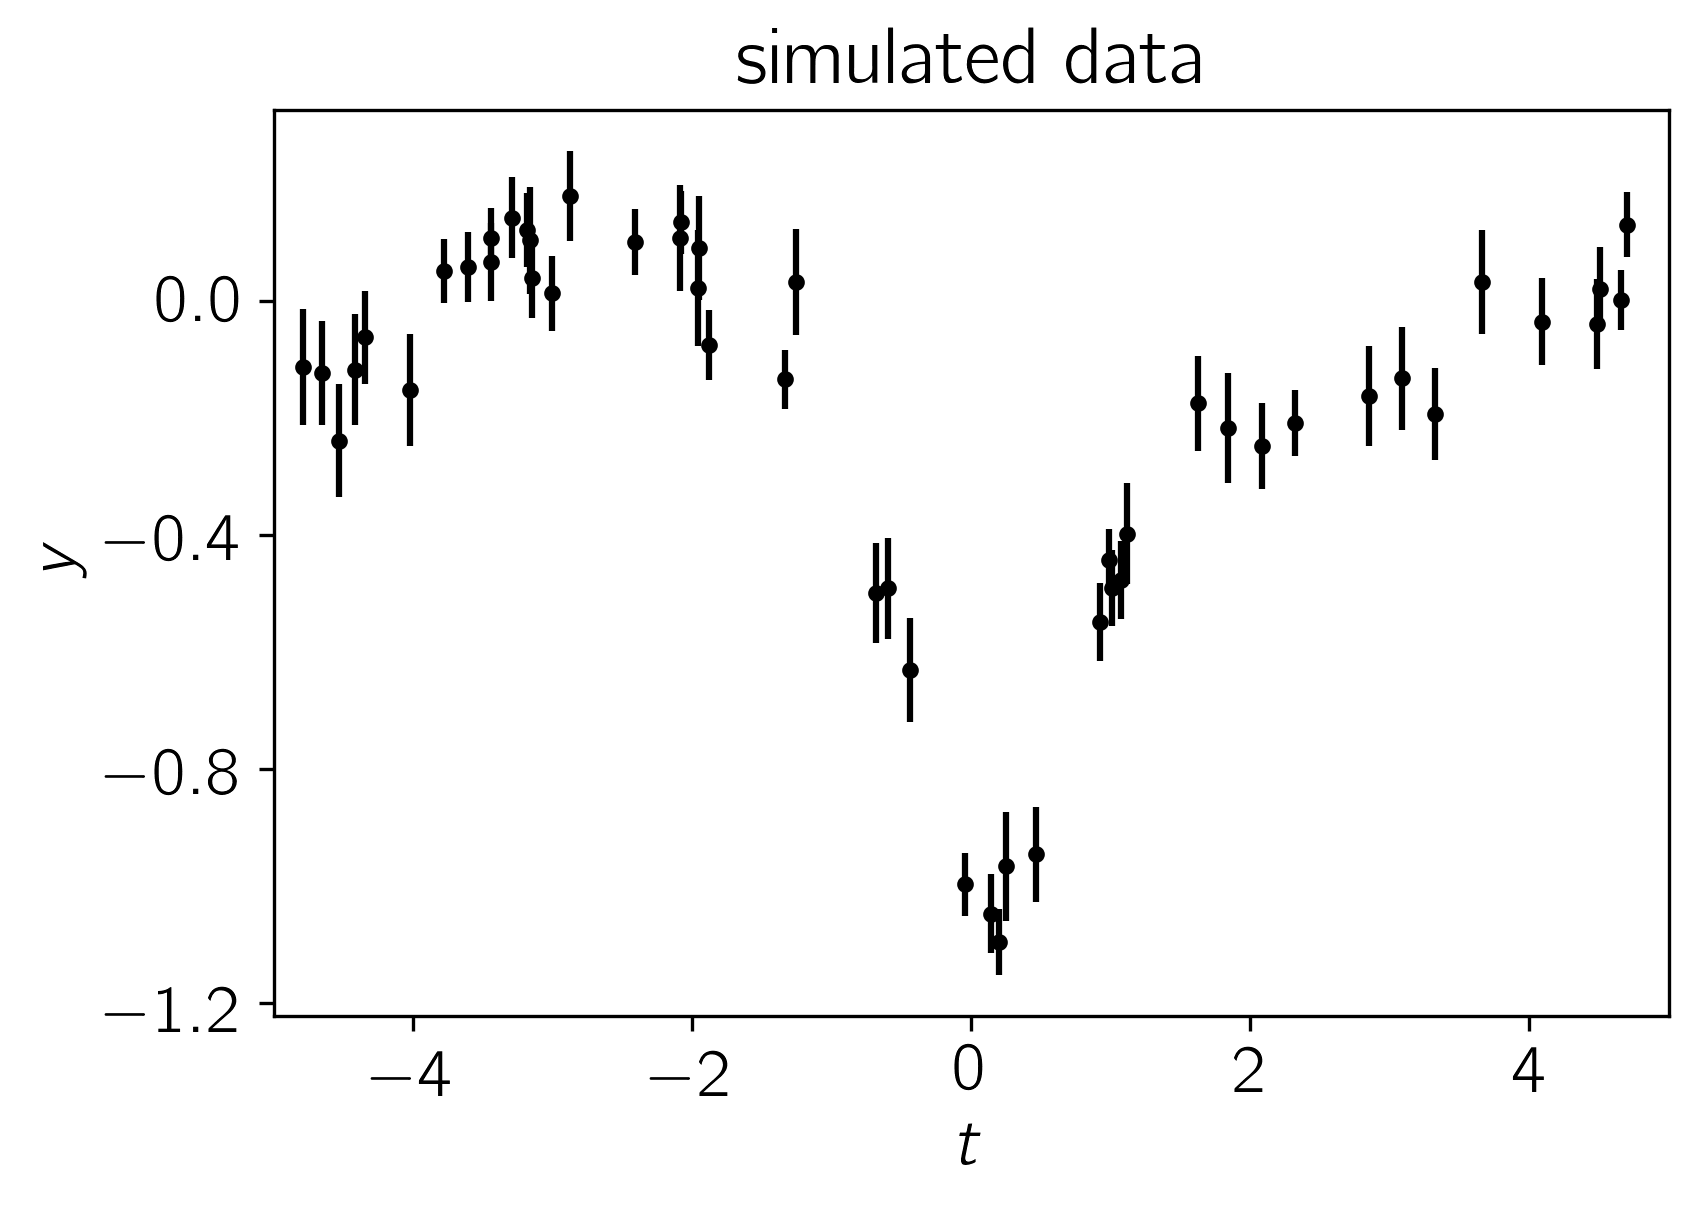

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from celerite.modeling import Model

# Define the model
class MeanModel(Model):
    parameter_names = ("alpha", "ell", "log_sigma2")
    
    def get_value(self, t):
        return self.alpha * np.exp(-0.5*(t-self.ell)**2 * np.exp(-self.log_sigma2))
    
    # This method is optional but it can be used to compute the gradient of the
    # cost function below.
    def compute_gradient(self, t):
        e = 0.5*(t-self.ell)**2 * np.exp(-self.log_sigma2)
        dalpha = np.exp(-e)
        dell = self.alpha * dalpha * (t-self.ell) * np.exp(-self.log_sigma2)
        dlog_s2 = self.alpha * dalpha * e
        return np.array([dalpha, dell, dlog_s2])

mean_model = MeanModel(alpha=-1.0, ell=0.1, log_sigma2=np.log(0.4))
true_params = mean_model.get_parameter_vector()

# Simuate the data
np.random.seed(42)
x = np.sort(np.random.uniform(-5, 5, 50))
yerr = np.random.uniform(0.05, 0.1, len(x))
K = 0.1*np.exp(-0.5*(x[:, None] - x[None, :])**2/10.5)
K[np.diag_indices(len(x))] += yerr**2
y = np.random.multivariate_normal(mean_model.get_value(x), K)

# Plot the data
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.xlim(-5, 5)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("simulated data");

## Modeling the Noise

**Note:** A full discussion of the theory of Gaussian processes is beyond the scope of this demo—you should probably check out [Rasmussen & Williams (2006)](http://www.gaussianprocess.org/gpml/)—but I'll try to give a quick qualitative motivation for our model.

In this section, instead of assuming that the noise is white, we'll include covariances between data points.
Under the assumption of Gaussianity, the likelihood function is

$$
    \ln p(\{y_n\}\,|\,\{t_n\},\,\{\sigma_n^2\},\,\theta) =
        -\frac{1}{2}\,\boldsymbol{r}^\mathrm{T}\,K^{-1}\,\boldsymbol{r}
        -\frac{1}{2}\,\ln\det K - \frac{N}{2}\,\ln 2\pi
$$

where

$$
    \boldsymbol{r} = \left ( \begin{array}{c}
        y_1 - f_\theta(t_1) \\
        y_2 - f_\theta(t_2) \\
        \vdots \\
        y_N - f_\theta(t_N) \\
    \end{array}\right)
$$

is the residual vector and $K$ is the $N \times N$ data covariance matrix (where :math:`N` is the
number of data points) with elements given by

$$
    K_{nm} = \sigma_n^2\,\delta_{nm} + k(t_n,\,t_m)
$$

where $\delta_{ij}$ is the [Kronecker delta](http://en.wikipedia.org/wiki/Kronecker_delta) and $k(\cdot,\,\cdot)$
is a covariance function that we get to choose.
We'll use a simple celerite `RealTerm`

$$
    k(\tau_{nm}) = a \, \exp \left (-c\,\tau_{nm} \right )
$$

where $\tau_{nm} = |t_n - t_m|$, and $a$ and $c$ are the
parameters of the model.


## The Fit

Now we could go ahead and implement the likelihood function that we came up
with in the previous section but celerite does that for us.
To implement the model from the previous section, we can write
the following likelihood function in Python and find it's maximum using scipy:

Initial log-likelihood: 49.899172867379185
Final log-likelihood: 54.018158109128926


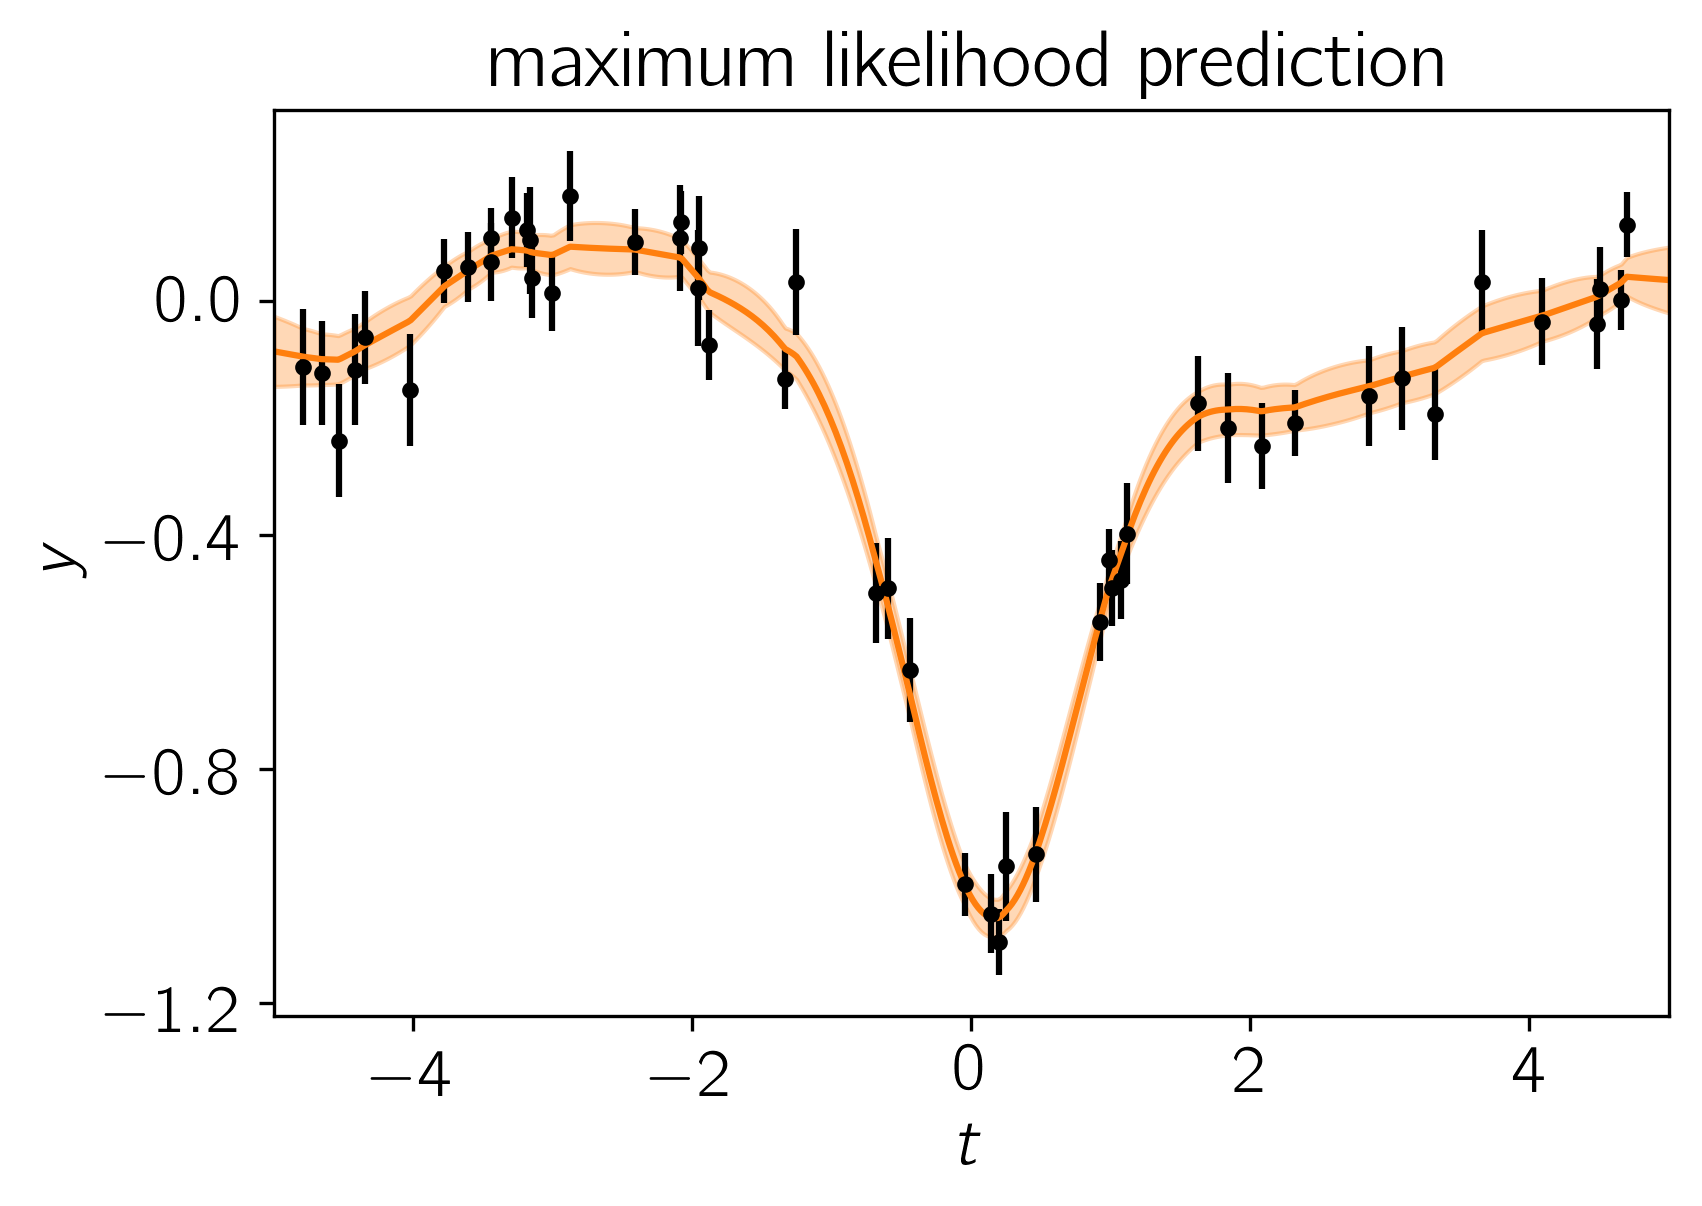

In [3]:
from scipy.optimize import minimize

import celerite
from celerite import terms

# Set up the GP model
kernel = terms.RealTerm(log_a=np.log(np.var(y)), log_c=-np.log(10.0))
gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
gp.compute(x, yerr)
print("Initial log-likelihood: {0}".format(gp.log_likelihood(y)))

# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))

# Make the maximum likelihood prediction
t = np.linspace(-5, 5, 500)
mu, var = gp.predict(y, t, return_var=True)
std = np.sqrt(var)

# Plot the data
color = "#ff7f0e"
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(t, mu, color=color)
plt.fill_between(t, mu+std, mu-std, color=color, alpha=0.3, edgecolor="none")
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.xlim(-5, 5)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("maximum likelihood prediction");

To fit this model using MCMC (using [emcee](http://dfm.io/emcee)), we need to first choose priors—in this case we’ll just use a simple uniform prior on each parameter—and then combine these with our likelihood function to compute the log probability (up to a normalization constant). In code, this will be:

In [4]:
def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(y) + lp

Now that we have our model implemented, we’ll initialize the walkers and run both a burn-in and production chain:

In [5]:
import emcee

initial = np.array(soln.x)
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 2000);

Running burn-in...
Running production...


After running the chain, we can plot the predicted results. It is often useful to plot the results on top of the data as well. To do this, we can over plot 24 posterior samples on top of the data:

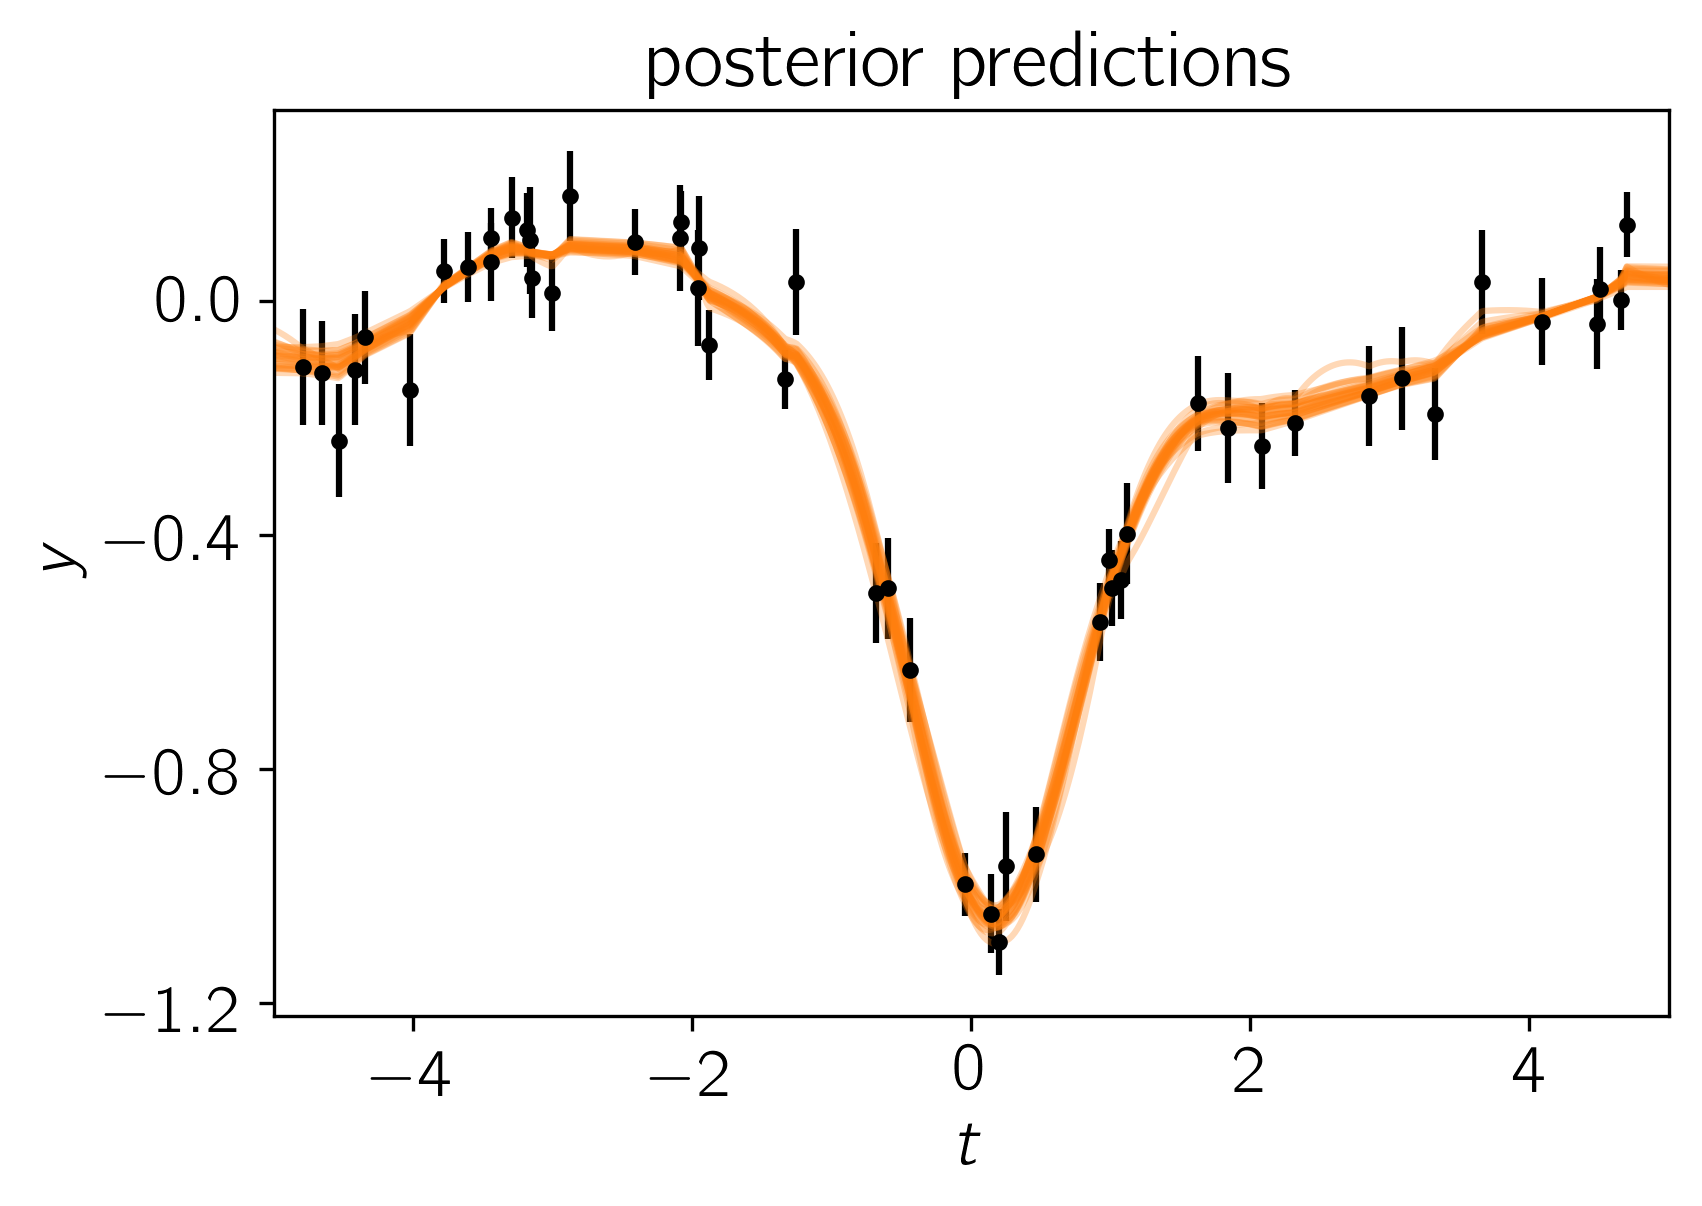

In [6]:
# Plot the data.
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(y, t, return_cov=False)
    plt.plot(t, mu, color=color, alpha=0.3)
    
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.xlim(-5, 5)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("posterior predictions");

In this figure, the data are shown as black points with error bars and the posterior samples are shown as translucent orange lines. These results seem pretty satisfying but, since we know the true model parameters that were used to simulate the data, we can assess the fit by comparing the inferences to the true values. To do this, we’ll plot all the projections of our posterior samples using [corner.py](https://github.com/dfm/corner.py) and over plot the true values:

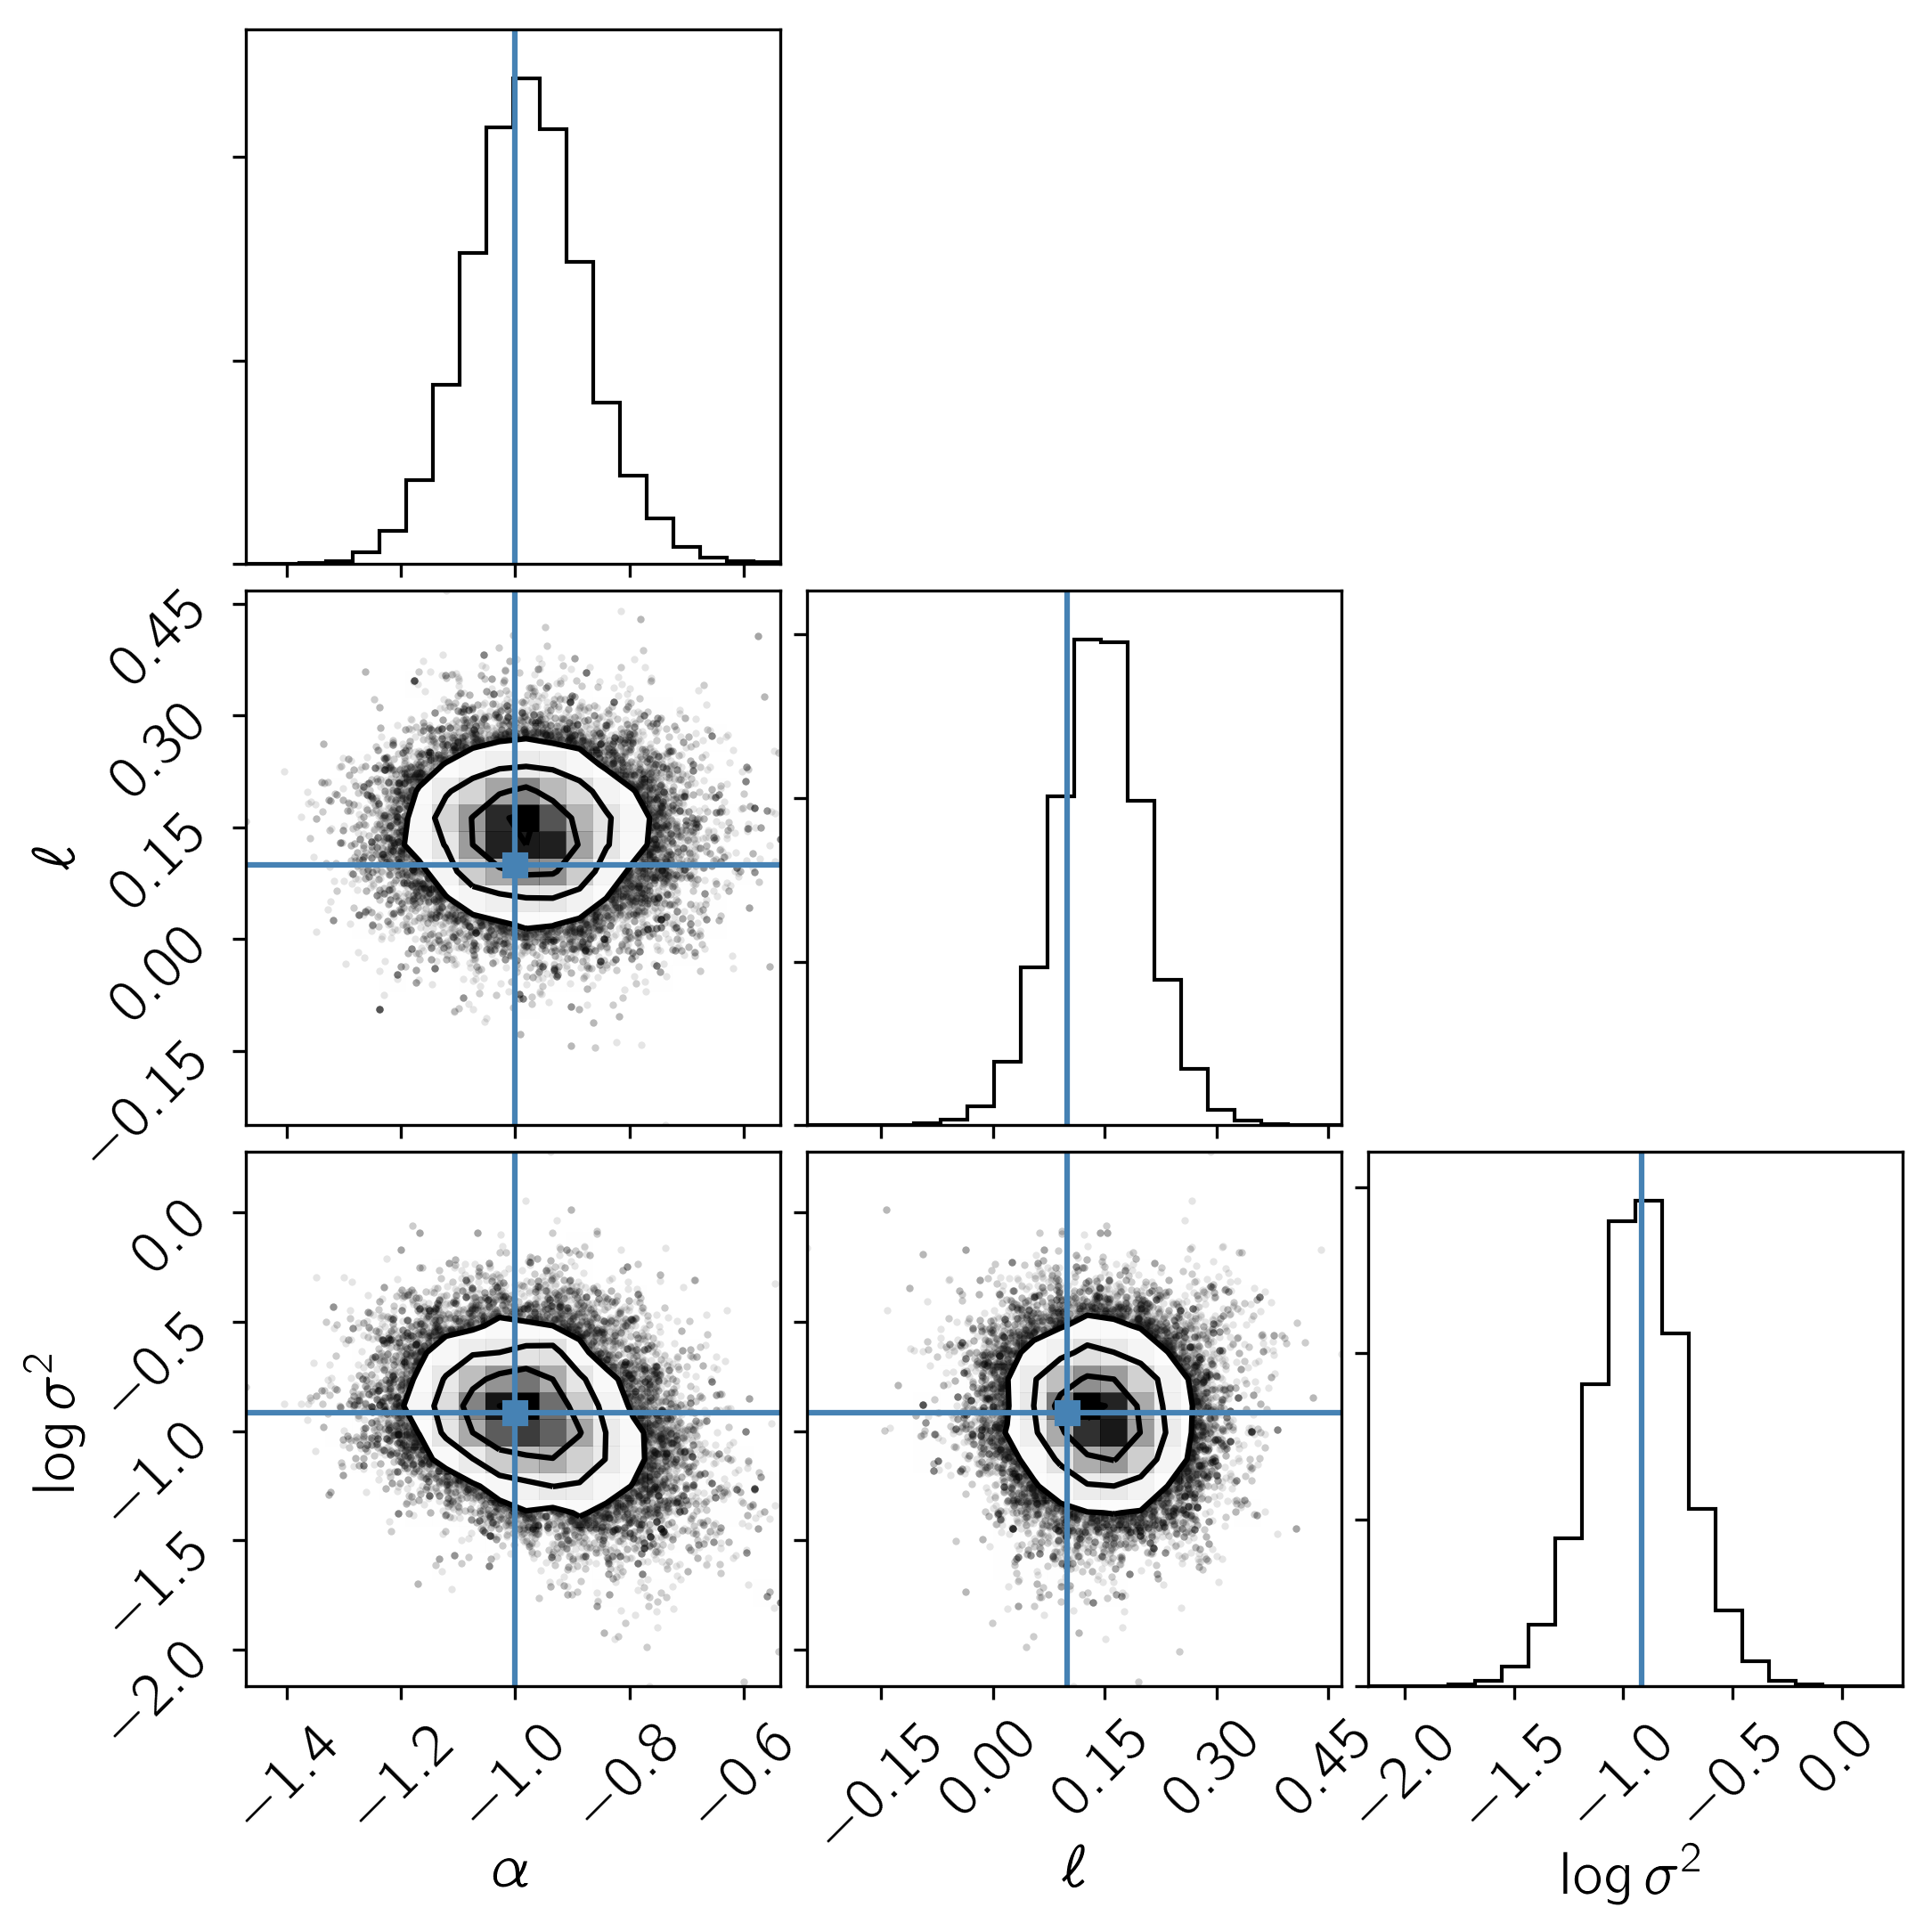

In [7]:
import corner
names = gp.get_parameter_names()
cols = mean_model.get_parameter_names()
inds = np.array([names.index("mean:"+k) for k in cols])
corner.corner(sampler.flatchain[:, inds], truths=true_params,
              labels=[r"$\alpha$", r"$\ell$", r"$\log\sigma^2$"]);

It is clear from this figure that the constraints obtained for the mean parameters when modeling the noise are reasonable even though our noise model was "wrong".